<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/movieLens_average/ave_movie_RSCCMM_CF_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

movieLens_average/ave_movie_RSCCMM_CF_compare.ipynb

In [17]:
#ライブラリ
import pandas as pd
import numpy as np
import random
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import csv

In [18]:
data_training = pd.read_excel('data_training.xlsx',index_col=0)
data_test = pd.read_excel('data_test.xlsx',index_col=0)

X = data_training.values[:, 1:]
TEST = data_test.values

print(X.shape)
print(TEST.shape)

(943, 1682)
(10000, 3)


In [19]:
# 未評価値を各ユーザーの平均評価値で補完
ave = np.empty((X.shape[0]))
for n in range(X.shape[0]):
    n_sum = 0
    for m in range(X.shape[1]):
        n_sum += X[n][m]
    if n_sum == 0:
        ave[n] = 0
    else:
        ave[n] = n_sum/np.count_nonzero(X,axis=1)[n]

X_movie = np.asarray(X, dtype = "float")

for n in range(X.shape[0]):
  for m in range(X.shape[1]):
    if X[n][m] == 0 :
      X_movie[n][m] = ave[n]

print(X_movie)

[[5.         3.         4.         ... 3.61065574 3.61065574 3.61065574]
 [4.         3.75438596 3.75438596 ... 3.75438596 3.75438596 3.75438596]
 [2.80392157 2.80392157 2.80392157 ... 2.80392157 2.80392157 2.80392157]
 ...
 [5.         4.04761905 4.04761905 ... 4.04761905 4.04761905 4.04761905]
 [4.27027027 4.27027027 4.27027027 ... 4.27027027 4.27027027 4.27027027]
 [3.42361111 5.         3.42361111 ... 3.42361111 3.42361111 3.42361111]]


In [20]:
#関数化
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    rough_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u = rough_u / rough_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, rough_u

In [21]:
#roopの回数を指定し、平均のaucを返す関数返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_AVE(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_sum = 0
  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = 1 if test[i][2] > 3 else 0

  for i in range(roop):
    r, rough_u = RSCCMM(X, C, delta)
    # print(f"各クラスターの要素数: {np.sum(rough_u, axis=1)}")

    n_overlaps = np.sum((np.sum(rough_u, axis=0) > 1).astype(np.float64))
    # print(f"オーバーラップしている要素の数: {n_overlaps}")
    # print(f"オーバーラップしていない要素の数: {X.shape[0] - n_overlaps}")

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]-1][test[j][1]-1]

    auc = roc_auc_score(test_true, r_test_score)
    auc_sum += auc

  return auc_sum/roop

print(RSCCMM_CF_AUC_AVE(1, TEST, X_movie, 5, -7.43))

0.7027857448988291


In [22]:
#RCCMM
def RCCMM_CF(X, C, a, b):
  n, m = X.shape
  u = np.zeros((C,n))
  w = np.zeros((C,m))
  s = np.zeros((C,n))
  r = np.zeros((n,m))
  r_ = np.zeros((n,m))

  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  for step in range(100):
    u_old = u.copy()
    u = np.zeros((C,n))

    s = np.log(w) @ X.T

    s_max = s.max(0)
    u = (s >= a * s_max + b).astype(np.float64)
    u /= u.sum(0)

    w = (u @ X) + sys.float_info.epsilon
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(u - u_old).max() == 0:
      break

  if any(u.sum(1) == 0):
    raise Exception('要素数0のクラスター発生')

  r = u.T @ w
  r_ = u.T @ np.log(w)

  return r, r_

In [23]:
#roopの回数を指定し、平均のaucを返す関数返す関数(RCCMM)
def RCCMM_CF_AUC_AVE(roop, test, X, C, alpha, beta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_sum = 0
  auc__sum = 0
  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)
  r__test_score = np.zeros(test_num)
  for i in range(test_num):
    test_true[i] = 1 if test[i][2] > 3 else 0

  for i in range(roop):
    r, r_ = RCCMM_CF(X, C, alpha, beta)

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]-1][test[j][1]-1]
      r__test_score[j] = r_[test[j][0]-1][test[j][1]-1]

    auc = roc_auc_score(test_true, r_test_score)
    auc_ = roc_auc_score(test_true, r__test_score)
    auc_sum += auc
    auc__sum += auc_

  return auc_sum/roop, auc__sum/roop

print(RCCMM_CF_AUC_AVE(10, TEST, X_movie, 30, 1.2, -5))

(0.7035475926295599, 0.7035483007981141)


movie_RSCCMM_HCCMM_compare
roop:  5
C:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
delta_list:  [-7.4277 -7.4287 -7.4297 -7.4307 -7.4317 -7.4327 -7.4337 -7.4347 -7.4357]
1 0.7035479770639178 -7.4277
2 0.7059267273778894 -7.4287
3 0.7064308381749468 -7.4287
4 0.7075810414941854 -7.4287
5 0.7076548043308029 -7.4287
6 0.70634147135007 -7.4287
7 0.7072713775954327 -7.4287
8 0.7070855703534906 -7.4277
9 0.7066683336279989 -7.4297
10 0.7087612630667721 -7.4287
11 0.7068731197871966 -7.4287
12 0.7062938621898327 -7.4287
13 0.707289818304587 -7.4287
14 0.7037861037986526 -7.430700000000001
15 0.7040631150570353 -7.4297
16 0.7036733067113214 -7.4297
17 0.7045991784192634 -7.4297
18 0.7032842672343238 -7.4297
19 0.7025819299422204 -7.4287
20 0.7039795268875617 -7.4297
21 0.7029922589892994 -7.4297
22 0.7020150187577663 -7.430700000000001
23 0.7021796982967252 -7.4297
24 0.7024221347429475 -7.4297
25 0.7020114172148331 -7.435700000000002
26 0.7022

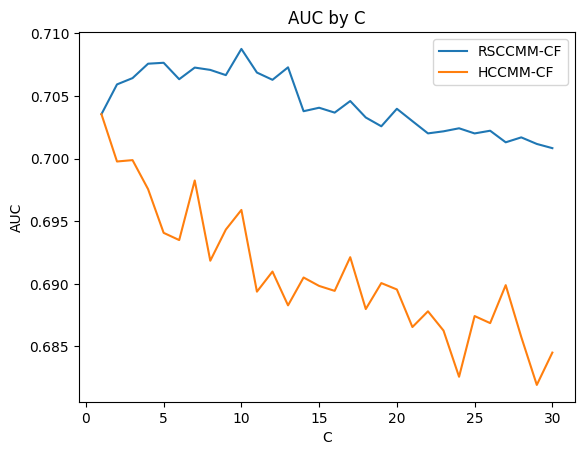

In [15]:
# 共通設定
name = "ave_movie_RSCCMM_HCCMM_compare"
print(name)
roop = 5
print("roop: ", roop)
x_C = np.arange(1,31,1)
print("C: ", x_C)
output_rows = []
output = [x_C.tolist()]


# RSCCMM-CFの設定
y_RSCCMM_auc_ave = []
delta_list = np.arange(-7.4277, -7.436, -0.001)
print("delta_list: ", delta_list )

output_rows.append(["", ', '.join(map(str, x_C)), "auc", ', '.join(map(str, delta_list)), "無し"])
for c in x_C:
  auc_ave_latest = 0
  delta_ = 0
  for delta in delta_list:
    auc_ave = RSCCMM_CF_AUC_AVE(roop, TEST, X_movie, c, delta)
    if auc_ave > auc_ave_latest:
      auc_ave_latest = auc_ave
      delta_ = delta
  print(c, auc_ave_latest, delta_)
  output_rows.append(["RSCCMM-CF", c, auc_ave_latest, delta_, 0])
  y_RSCCMM_auc_ave.append(auc_ave_latest)

output.append(y_RSCCMM_auc_ave)


# RCCMM-CFの設定
y_RCCMM_auc_ave = []
# RCCMM_alpha_list = np.arange(1.2, 1.6, 0.05)
# RCCMM_beta_list = np.arange(0,-10,-1)
RCCMM_alpha_list = np.array([1.0])
RCCMM_beta_list = np.array([0.0])
print("alpha_list: ", RCCMM_alpha_list)
print("beta_list: ", RCCMM_beta_list)

output_rows.append(["", ', '.join(map(str, x_C)), "auc", ', '.join(map(str, RCCMM_alpha_list)), ', '.join(map(str, RCCMM_beta_list))])
for c in x_C:
  auc_ave = 0
  alpha_ = 0
  beta_ = 0
  for alpha in RCCMM_alpha_list:
    for beta in RCCMM_beta_list:
      ave, ave_ = RCCMM_CF_AUC_AVE(roop, TEST, X_movie, c, alpha, beta)
      if ave > auc_ave:
        auc_ave = ave
        alpha_ = alpha
        beta_ = beta

  output_rows.append(["HCCMM-CF", c, auc_ave, alpha_, beta_])
  y_RCCMM_auc_ave.append(auc_ave)

output.append(y_RCCMM_auc_ave)


# 画像出力
plt.plot(x_C, y_RSCCMM_auc_ave, label="RSCCMM-CF")
# plt.plot(x_C, y_RCCMM_auc_ave, label="RCCMM-CF")
plt.plot(x_C, y_RCCMM_auc_ave, label="HCCMM-CF")
#plt.xticks(x_C, x_C)
plt.legend()
plt.title('AUC by C')
plt.xlabel('C')
plt.ylabel('AUC')
#plt.grid(True)
plt.savefig(f"{name}.png", format="png", dpi=300)

#csv出力
with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output)

output_info = [["手法", "クラスター数", "AUC", "パラメータ1", "パラメータ2"]]
for row in output_rows:
  output_info.append(row)

with open(f'{name}_info.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output_info)

In [16]:
# csvデータから再現
name = "ave_movie_RSCCMM_HCCMM_compare"
labels=["RSCCMM-CF", "HCCMM-CF"]
input = pd.read_csv(f'{name}.csv', header=None)

input_x_C = input.values[0] # Cのリスト
input_y_RSCCMM_auc = input.values[1] # RSCCMM-CF results
input_y_RCCMM_auc = input.values[2] # RCCMM-CF resulets

print(input_x_C)
print(input_y_RSCCMM_auc)
print(input_y_RCCMM_auc)

plt.plot(input_x_C, input_y_RSCCMM_auc, marker = 'o', label=labels[0])
plt.plot(input_x_C, input_y_RCCMM_auc, marker = "o", label=labels[1])


plt.legend()
plt.title('AUC by C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig(f"{name}.png", format="png", dpi=300)

FileNotFoundError: ignored